# [셀프리뷰 프로젝트] 3. 캐글 EDA

✔︎ 이번 프로젝트의 진행방식은 다음과 같습니다 :
- '셀프리뷰 프로젝트'는 코치의 리뷰를 거치지 않는 프로젝트입니다.
- 첨부된 파일에 안내된 절차에 따라 최소 5~10줄 이내의 간단한 코드를 작성함으로 스스로의 실력을 체크할 수 있습니다.
- 프로젝트 수행 결과 화면을 캡처 및 제출시, 담당코치가 훈련생 분의 학습현황을 파악하고 채점을 진행합니다.

✔︎ 프로젝트 수행에 어려움을 겪고 있다면?
- 만약 프로젝트 수행에 어려움을 겪고 있거나 제출을 끝냈다면, 코치 1:1 문의를 통해 예시 정답을 요청해 보세요.
- 웍스와 자유게시판을 통해 다른 훈련생들과 문제점을 공유하고 해결방안을 도모하는 것도 좋은 방법입니다.

In [3]:
#라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#Data 불러오기
train_data_path = join('./data/kaggle-kakr-housing-data', 'train.csv')
sub_data_path = join('./data/kaggle-kakr-housing-data', 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## 1. EDA (1) : 라벨 제거 및 결측치 확인

In [ ]:
# 앞선 프로젝트에서 저장한 train data 에서 불필요한 값을 제거합니다.
# isna() 함수로 결측치를 확인하고, describe() 함수를 활용해 기본적인 통계량를 확인합니다.
# missingno 라이브러리를 통해 결측치를 시각화하고, 변수들의 분포를 확인합니다.

### [TODO] 1_ 학습 데이터에서 라벨 제거하기

학습데이터인 `data`는 테스트 데이터인 `sub`와 달리 우리가 예측해야 할 `price`란  컬럼을 하나 더 가지고 있습니다. 이제부터 학습데이터(`data`)의 `price`를 `y`라는 정답을 담는 변수로 옮기고 `data`에서는 `price`컬럼을 제거 하려고 합니다.

이를 직접 구현해 보세요.

```
[힌트]
- 파이썬의 del 명령어를 사용하여 특정컬럼을 지울 수 있습니다
- pandas.DataFrame.drop도 활용할 수 있습니다

```

In [4]:
# data의 price를 y로 옮기기
y = data['price']

del data['price']

코드를 잘 작성하셨다면 아래의 `data.colums`를 출력하였을 때 Index에 'price'가 없어야 합니다.

In [5]:
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


모델을 학습시키기 전에 학습데이터와 테스트 데이터를 합쳐서 전체 데이터가 어떤 특성을 보이고 있는지 살펴보려고 합니다. 특성을 살펴보고 난 후엔 다시 분리하여 학습을 진행할것 입니다.
이를위해 학습데이터(`data`)의 개수를 저장하여 합쳐진 데이터에서 분리할 것 입니다.
아래의 코드는 이를 실행합니다.

In [6]:
train_len = len(data) # 학습데이터의 수
data = pd.concat((data, sub), axis=0) # 학습데이터와 테스트 데이터 합치기

print(len(data)) # 합쳐진 데이터의 수
data.head() # 데이터 확인

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


`data`를 확인해보면 `data`와 `sub`가 잘 합쳐진 것을 확인하실 수 있을 겁니다.
이제부터 데이터에 결측치가 있는지 확인해보겠습니다.

그리고 `info()`함수로 데이터 타입 및 null 체크를 해보겠습니다.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_living1

### [TODO] 2_ 결측치 데이터의 비율 계산하기

위 `info`함수를 이용하면 각 컬럼에 null 데이터가 몇개 존재하는지 확인할 수있습니다. 아래에서는 유사한 방법으로 `isna()`로 결측치 데이터를 확인하고 그 수를 `sum()`함수로 세어보겠습니다.

- 참고 : [`isna()`](https://pandas.pydata.org/docs/reference/api/pandas.isna.html)와 [`sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)

In [13]:
null = pd.isna(data)
missing = np.sum(null) 
print(missing)

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


출력하였을 때 다음과 같은 결과가 나오면 됩니다.

> id               0 <br>
date             0 <br>
price            0 <br>
bedrooms         0 <br>
bathrooms        0 <br>
sqft_living      0 <br>
sqft_lot         0 <br>
floors           0 <br>
waterfront       0 <br>
view             0 <br>
condition        0 <br>
grade            0 <br>
sqft_above       0 <br>
sqft_basement    0 <br>
yr_built         0 <br>
yr_renovated     0 <br>
zipcode          0 <br>
lat              0 <br>
long             0 <br>
sqft_living15    0 <br>
sqft_lot15       0 <br>
dtype: int64 <br>



이제 missing을 전체 데이터의 수로 나눈다면 컬럼별 결측치 데이터의 비율을 알 수 있게 됩니다.

In [14]:
missing/data.shape[0]

id               0.0
date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

`describe()`함수를 이용하면 수치형 데이터의 기본적인 통계량을 확인해볼 수 있습니다. 이를 활용해 봅니다.

In [15]:
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### [TODO] 3_ `missingno` 라이브러리로 결측치 데이터 시각화 하기

결측치 데이터를 시각화하면 결측치를 어떻게 처리할지 통찰을 얻을 수도 있습니다. 이를 위해서 `missingno` 라이브러리의 [`matrix`](https://github.com/ResidentMario/missingno#matrix) 함수를 이용할 수 있습니다.

`data`를 `missingno` 라이브러리를 활용하여 시각화해보세요.

msno를 활용하여 시각화하면, 위에서 계산한 것처럼 결손치 데이터가 없기 때문에 까맣게 나왔을 겁니다. 시각화를 통해 결손치를 발생 시키는 원인이 어떤 컬럼으로부터 기인했는지 유추해 볼 수 있고 적절한 결손치 처리 방법에 대한 아이디어를 얻을 수 있습니다.

<Axes: >

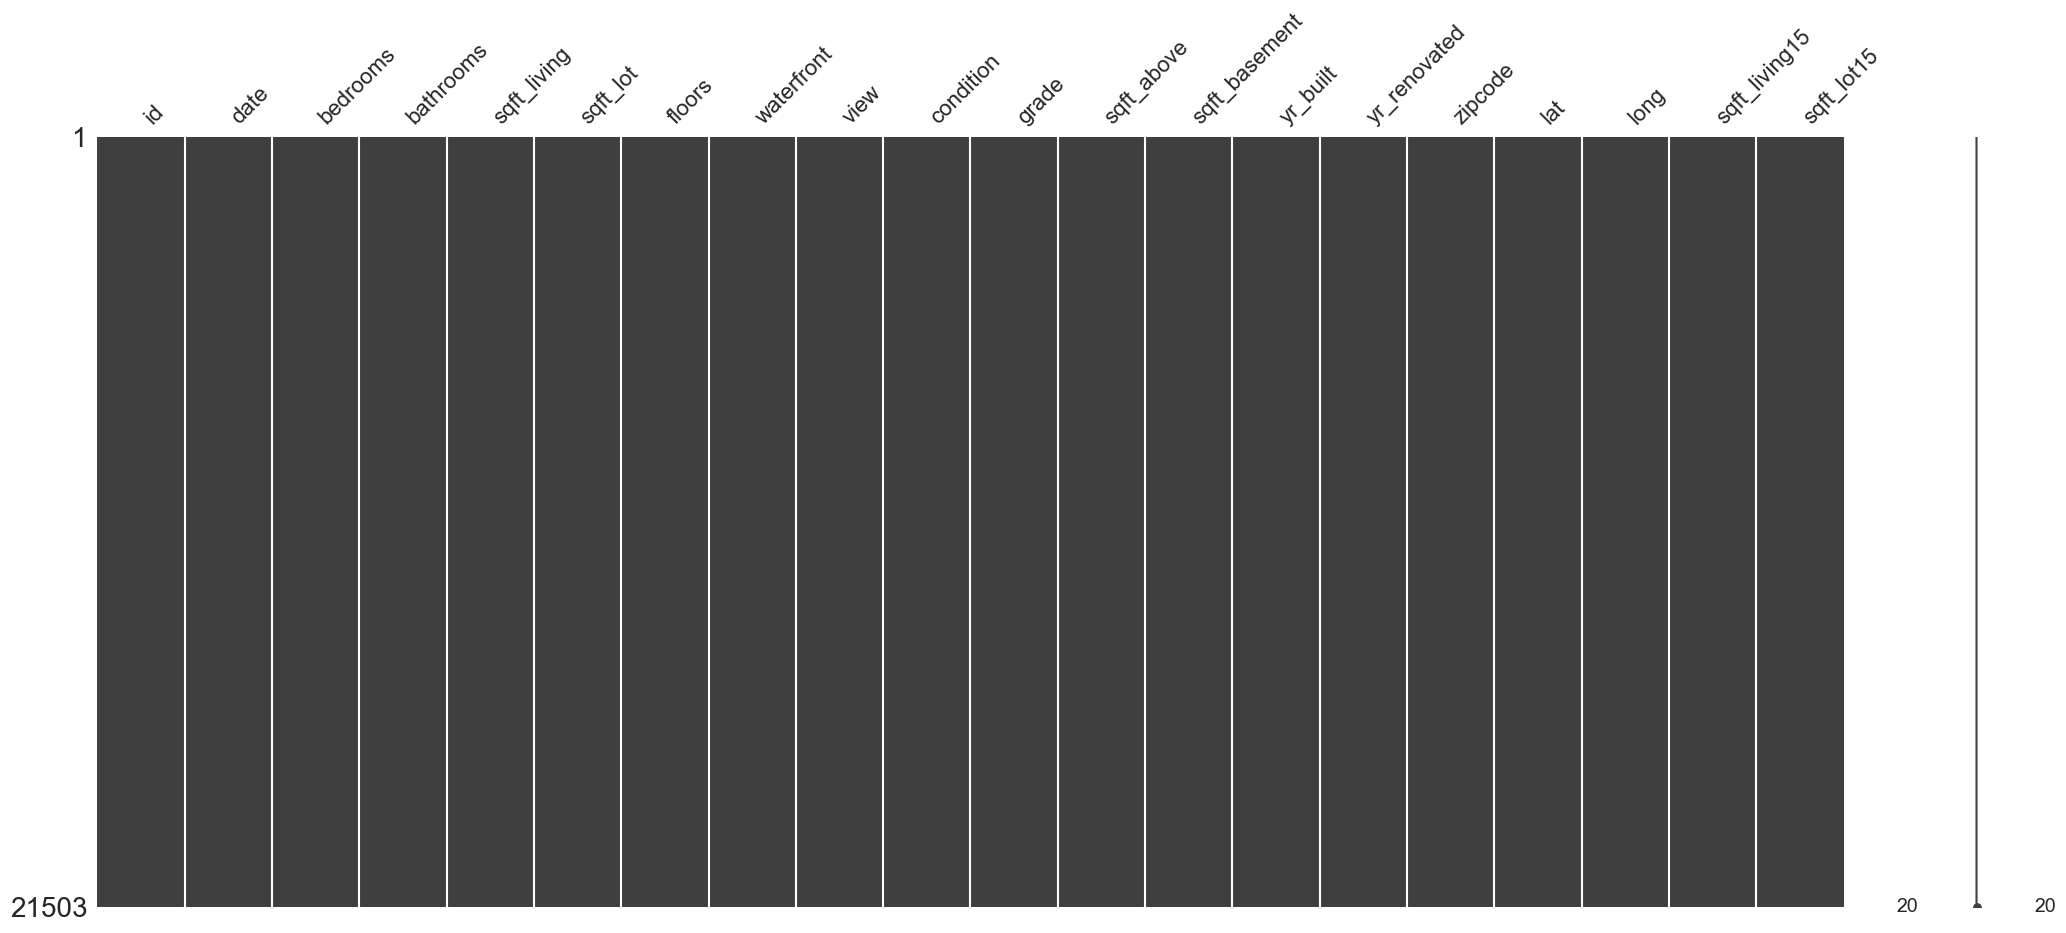

In [16]:
import missingno as msno # 라이브러리 임포트

# data에 결손치를 missingno 라이브러리를 이용하여 시각화 해보세요.

msno.matrix(data)

### 4_ 불필요한 변수 정리하기

**id컬럼 제거하기**

우리의 목표는 `price`를 예측하는 것이기 때문에 필요없는 `id`를 제거하겠습니다. 그전에 제출할때 대비하여 `sub_id` 변수에 `id` 컬럼을 저장해 두고 지우겠습니다.

In [17]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**date 컬럼 자르기**

date 컬럼의 값을 보면 다음과 같은 형식으로 되어있는 것을 확인할 수 있습니다.
- 예시 : `20141013T000000`

우리는 연/월 데이터만 사용하기 위해 `201410` 까지 자르기 변환을 수행할 것 입니다. 이를 위해서 아래의 코드를 실행합니다.

In [18]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. EDA(2) : 로그 변환

In [ ]:
# 분포가 치우쳐진 변수들에 대해 로그 변환을 진행하고, 데이터를 정규분포에 가깝게 만듭니다.
# 변환한 데이터를 다시 train data 와 test data 로 나누어 저장합니다.

### [TODO] 5_ 각 변수들의 분포 확인 및 변환하기

전체 데이터들의 분포를 확인합니다.
특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.

아래 시각화 코드는 id 컬럼과 date컬럼을 제외한 18개 컬럼에 대해 한 번에 모든 그래프의 분포를 그려주는 코드입니다.
9행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용하고 있군요.

그래프의 종류는 [sns.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)을 사용합니다.
kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.


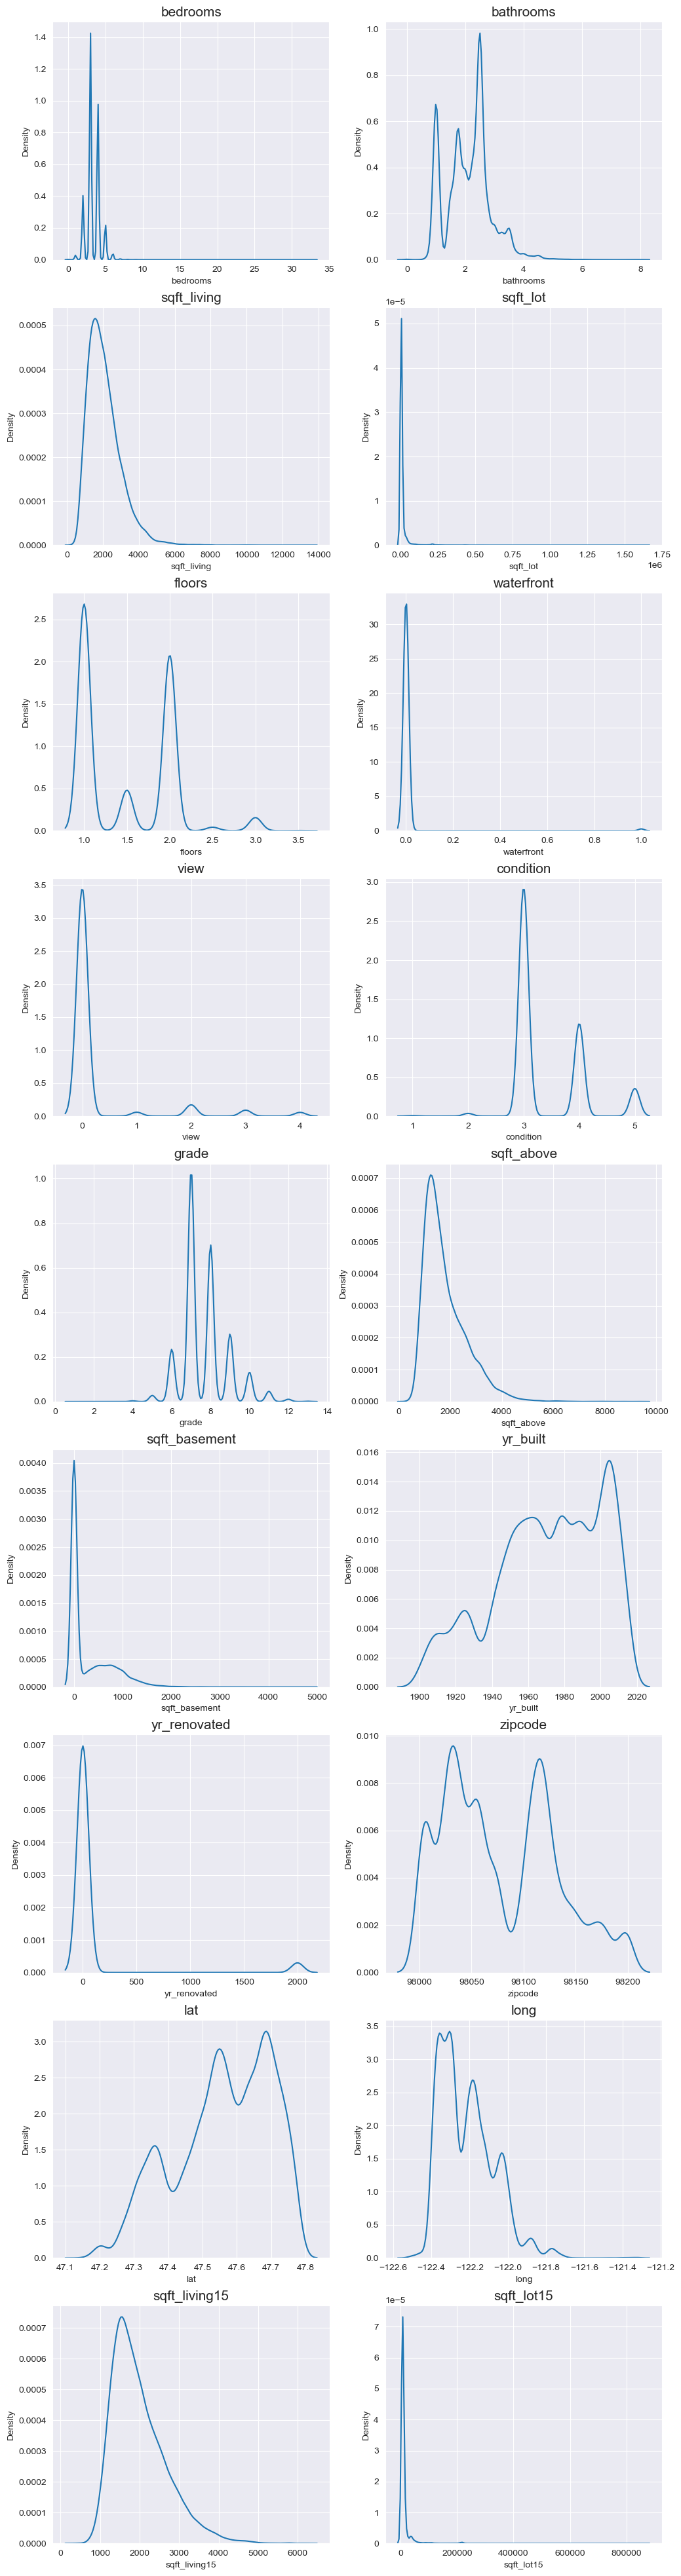

In [19]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# date 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

위 그래프 중에서는 `bedrooms`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_living15`, `sqft_lot15` 변수가 한쪽으로 치우친 경향을 보이는군요.

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다.




**로그변환 수행하기 (log-scaling)**

아래와 같이 치우친 컬럼들을 `skew_columns` 리스트 안에 담고, 모두 [`np.log1p()`](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html)를 활용해서 로그 변환을 해주도록 하겠습니다. `numpy.log1p()`함수는 입력배열의 각 요소에 대해 자연로그 log(1+x)을 반환해 주는 함수 입니다.

In [26]:
# 치우친 분포의 컬럼을 저장해 두기
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c])


log(1+x)변환을 완료하셨나요? 취우쳐 있던 `skew_colums`만을 다시 `sns.kdeplot`으로 출력해보도록 하겠습니다. 이전 출력보다 치우침이 줄어드는것이 확인 되었다면 코드블록 3-4 를 잘 구현하신것 입니다.


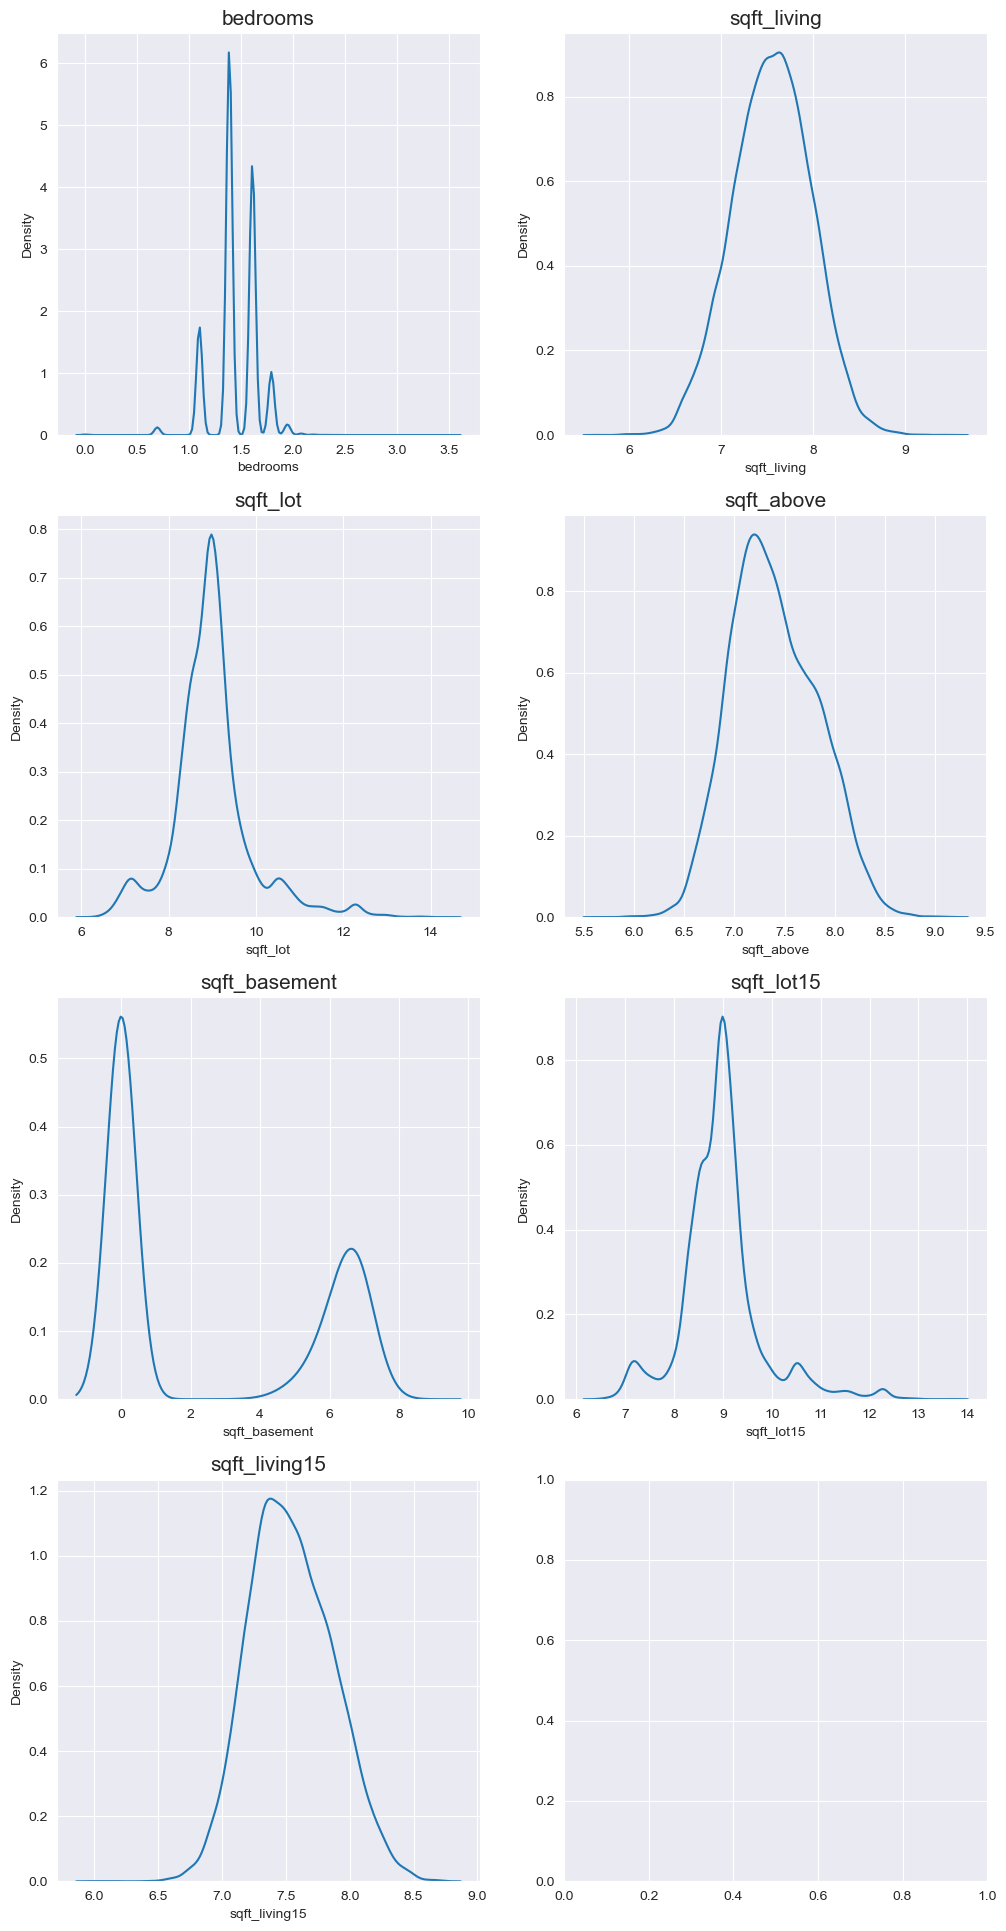

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

그렇다면 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요?
이는 로그 함수의 형태를 보면 알 수 있습니다. 아래의 일반적인 로그 함수를 살펴봅시다.

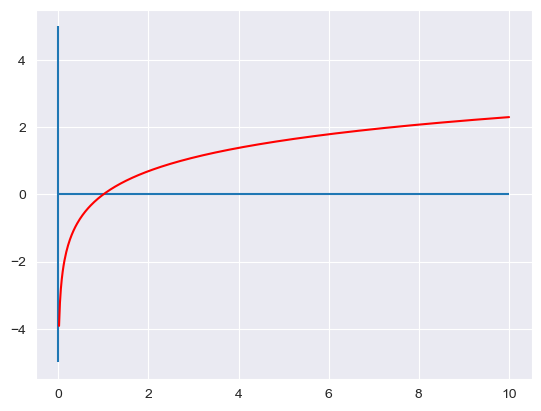

In [22]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위와 같은 로그 함수의 특징은 다음과 같습니다.

- 0<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (−∞,0)으로 매우 큽니다.
- 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
- 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가집니다.

위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포하게 될 수 있는지 이해가 되시나요? 그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 `data[price]`의 분포를 로그 변환했을 때 결과를 유추해봅시다. 원래 price의 분포는 다음과 같습니다.

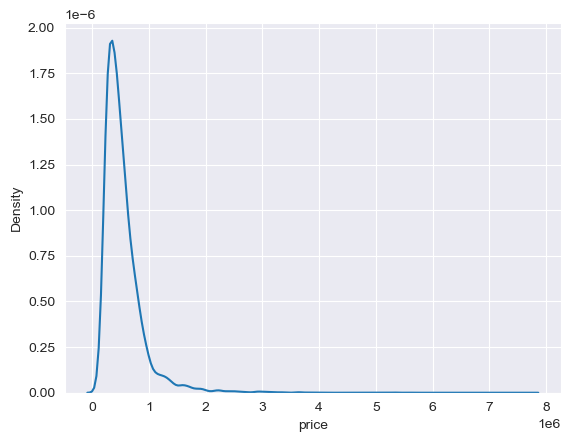

In [23]:
sns.kdeplot(y) # y는 코드블록 3-2 에서 price를 저장하고 있음.
plt.show()

직접 확인해봅시다!

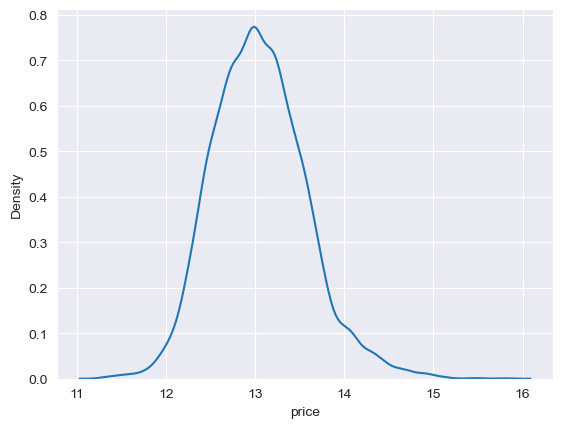

In [24]:
y_log_transformation = np.log1p(y) # 코드블록 3-4 의 힌트가 되겠네요 ^^

sns.kdeplot(y_log_transformation)
plt.show()

확실히 아름다운 정규분포의 모양으로 가까워진 것으로 보입니다!

### 6_ 다시 학습데이터와 테스트 데이터 분리하기

여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.

위에서 저장해두었던 `train_len`을 인덱스로 활용해서 `:train_len`까지는 학습 데이터, 즉 `x`에 저장하고, `train_len:` 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 `sub` 변수에 저장합니다.

In [27]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


여러분, 이제 데이터 준비를 마쳤습니다. 다음 시간에는 실제 모델을 적용하여 price를 예측해보고 그 결과를 캐글 대회에 제출해보도록 하겠습니다.

## 3. 셀프리뷰 진행하기

- 수행한 프로젝트 내용을 확인하고, 셀프리뷰를 진행합니다.
- 내가 작성한 코드에 오류는 없는지 또는 더 나은 방법은 없는지 고민해 봅니다.
- 리뷰를 완료했다면, 실행 결과 화면을 캡쳐 및 제출하여 수행여부를 증빙합니다. (파일첨부 NO! 본문에 이미지 삽입 YES!)
- 이번 차시에 궁금한 점이 있다면, 제출시 본문에 내용을 함께 작성하여 제출할 수 있습니다.

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.